In [2]:
zcx/*901.


In [ ]:
#Link: https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65

In [1]:
import numpy as np 
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline

In [29]:
data= pd.read_csv('kc_house_data - Copy1.csv')
data.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,13-10-14,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,09-12-14,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,25-02-15,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,09-12-14,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,18-02-15,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [30]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 


# Categorical Pipeline

In [31]:
#Custom transformer that breaks dates column into year, month and day into separate columns and
#converts certain features to binary 
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes in a list of values as its argument
    def __init__(self, use_dates = ['year', 'month', 'day'] ):
        self._use_dates = use_dates
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self

    #Helper function to extract year from column 'dates' 
    def get_year( self, obj ):
        return str(obj)[:4]
    
    #Helper function to extract month from column 'dates'
    def get_month( self, obj ):
        return str(obj)[4:6]
    
    #Helper function to extract day from column 'dates'
    def get_day(self, obj):
        return str(obj)[6:8]
    
    #Helper function that converts values to Binary depending on input 
    def create_binary(self, obj):
        if obj == 0:
            return 'No'
        else:
            return 'Yes'
    
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
       #Depending on constructor argument break dates column into specified units
       #using the helper functions written above 
       for spec in self._use_dates:
        
        exec( "X.loc[:,'{}'] = X['date'].apply(self.get_{})".format( spec, spec ) )
       #Drop unusable column 
       X = X.drop('date', axis = 1 )
       
       #Convert these columns to binary for one-hot-encoding later
       X.loc[:,'waterfront'] = X['waterfront'].apply( self.create_binary )
       
       X.loc[:,'view'] = X['view'].apply( self.create_binary )
       
       X.loc[:,'yr_renovated'] = X['yr_renovated'].apply( self.create_binary )
       #returns numpy array
       return X.values 

# Numerical Pipeline

In [32]:
#Custom transformer we wrote to engineer features ( bathrooms per bedroom and/or how old the house is in 2019  ) 
#passed as boolen arguements to its constructor
class NumericalTransformer(BaseEstimator, TransformerMixin):
    #Class Constructor
    def __init__( self, bath_per_bed = True, years_old = True ):
        self._bath_per_bed = bath_per_bed
        self._years_old = years_old
        
    #Return self, nothing else to do here
    def fit( self, X, y = None ):
        return self 
    
    #Custom transform method we wrote that creates aformentioned features and drops redundant ones 
    def transform(self, X, y = None):
        #Check if needed 
        if self._bath_per_bed:
            #create new column
            X.loc[:,'bath_per_bed'] = X['bathrooms'] / X['bedrooms']
            #drop redundant column(())
            X.drop('bathrooms', axis = 1 )
        #Check if needed     
        if self._years_old:
            #create new column
            X.loc[:,'years_old'] =  2019 - X['yr_built']
            #drop redundant column 
            X.drop('yr_built', axis = 1)
            X.drop('id', axis=1)
            
        #Converting any infinity values in the dataset to Nan
        X = X.replace( [ np.inf, -np.inf ], np.nan )
        #returns a numpy array
        return X.values

# Combining the pipelines together

In [33]:
#Categrical features to pass down the categorical pipeline 
categorical_features = ['date', 'waterfront', 'view', 'yr_renovated']

#Numerical features to pass down the numerical pipeline 
numerical_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                'condition', 'grade', 'sqft_basement', 'yr_built']

#Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', FeatureSelector(categorical_features) ),
                                  
                                  ( 'cat_transformer', CategoricalTransformer() ), 
                                  
                                  ( 'one_hot_encoder', OneHotEncoder( sparse = False ) ) ] )
    
#Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', FeatureSelector(numerical_features) ),
                                  
                                  ( 'num_transformer', NumericalTransformer() ),
                                  
                                  ('imputer', SimpleImputer(strategy = 'median') ),
                                  
                                  ( 'std_scaler', StandardScaler() ) ] )

#Combining numerical and categorical piepline into one full big pipeline horizontally 
#using FeatureUnion
full_pipeline = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', categorical_pipeline ), 
                                                  
                                                  ( 'numerical_pipeline', numerical_pipeline ) ] )

In [34]:
full_pipeline

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FeatureUnion(transformer_list=[('categorical_pipeline',
                                Pipeline(steps=[('cat_selector',
                                                 FeatureSelector(feature_names=None)),
                                                ('cat_transformer',
                                                 CategoricalTransformer(use_dates=None)),
                                                ('one_hot_encoder',
                                                 OneHotEncoder(sparse=False))])),
                               ('numerical_pipeline',
                                Pipeline(steps=[('num_selector',
                                                 FeatureSelector(feature_names=None)),
                                                ('num_transformer',
                                                 NumericalTransformer(bath_per_bed=None,
                                                                      years_old=None)),
                                 

# Now applying model

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Leave it as a dataframe becuase our pipeline is called on a 
#pandas dataframe to extract the appropriate columns, remember?
X = data.drop('price', axis = 1)
#You can covert the target variable to numpy 
y = data['price'].values 

X_train, X_test, y_train, y_test = train_test_split( X, y , test_size = 0.2 , random_state = 42 )

#The full pipeline as a step in another pipeline with an estimator as the final step
full_pipeline_m = Pipeline( steps = [ ( 'full_pipeline', full_pipeline),
                                  
                                  ( 'model', LinearRegression() ) ] )

#Can call fit on it just like any other pipeline
full_pipeline_m.fit( X_train, y_train )

#Can predict with it like any other pipeline
y_pred = full_pipeline_m.predict( X_test ) 

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

KeyError: "['id'] not found in axis"

In [36]:
data1={'y_test':y_test,'y_pred':y_pred}


In [37]:
pred_df= pd.DataFrame(data1, columns=['y_test','y_pred'])
pred_df

,y_test,y_pred
0,132500,127248.0
1,415000,313456.0
2,494000,333792.0
3,355000,312048.0
4,606000,368096.0
...,...,...
4315,175000,220336.0
4316,394950,516784.0
4317,437000,513072.0
4318,293000,382432.0


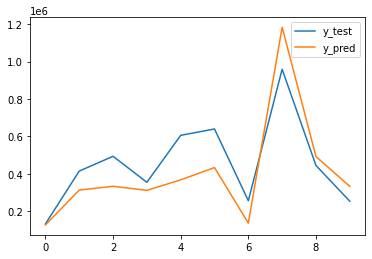

In [38]:
pred_df[:10].plot()